# DVD Inversion exercise (GNSS- Low Noise)

This is the noteboook that solves the inversion exercise using just GNSS dataset

## Import libraries

In [1]:
%matplotlib inline
import numpy as np
import corner
import matplotlib.pyplot as plt
import matplotlib
import h5py
from vmod import util
from vmod.data import Gnss
from vmod.source import Mctigue
from vmod.inverse import Inverse

## Read dataset

In [2]:
csvfile='examples/dvd/gps/Synth_ENU_Low_Gaussian.csv'
xs,ys,uxs,uys,uzs=np.loadtxt(csvfile,skiprows=1,delimiter=',',unpack=True)
euxs=xs*0+1e-3
euys=np.copy(euxs)
euzs=np.copy(euxs)
names=[str(i).zfill(4) for i in range(len(xs))]

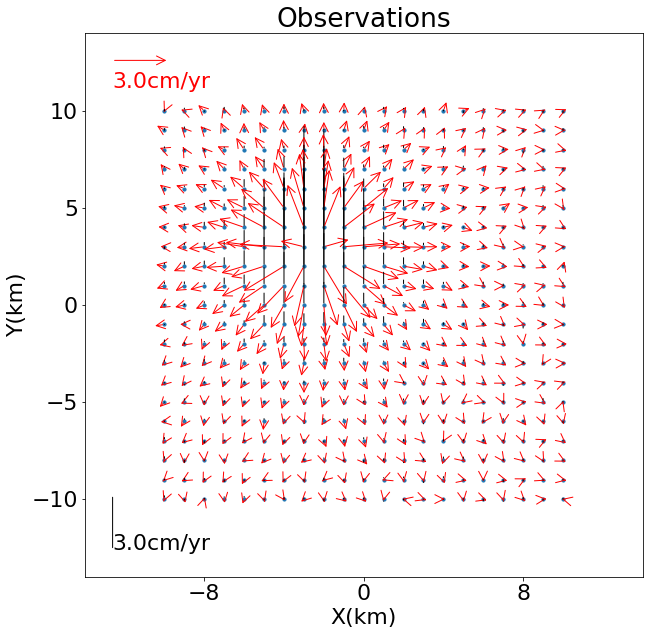

In [20]:
plt.rcParams.update({'font.size': 22})
util.plot_gnss(xs,ys,uxs,uys,uzs,title='Observations',scl=3.0,figsize=(10,10))

## Create data object

In [4]:
obs=Gnss()

obs.add_names(names)

obs.add_xs(xs)
obs.add_ys(ys)

obs.add_ux(uxs)
obs.add_uy(uys)
obs.add_uz(uzs)

obs.add_errx(euxs)
obs.add_erry(euys)
obs.add_errz(euzs)

#obs.importcsv('examples/gps/fisher_gnss.txt')

## Create Model object

In [5]:
mct = Mctigue(obs)
uxsm,uysm,uzsm=mct.forward([0,0,2.0e3,5e2,1e6],unravel=False)

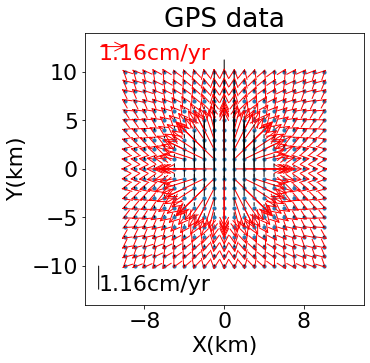

In [6]:
util.plot_gnss(xs,ys,uxsm,uysm,uzsm)

## Create Inversion object

In [7]:
mct.set_x0([0,0,2.0e3,5e2,1e6])
#Bounds for parameters
mct.set_bounds(low_bounds = [-10000,-10000,5e2,1e1,1e5], high_bounds = [10000,10000,1e4,5e3,1e7])

inv=Inverse(obs)
inv.register_source(mct)

## Least-squares Inversion

In [8]:
ans=inv.nlsq()

print(ans.x)

36.36328950168911
[-2.51704804e+03  2.87286709e+03  2.18446072e+03  1.01452027e+03
  1.27400018e+06]


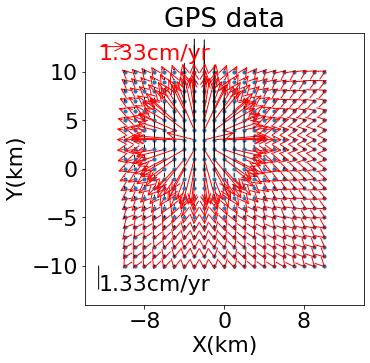

In [9]:
uxsm,uysm,uzsm=mct.forward(ans.x,unravel=False)

util.plot_gnss(xs,ys,uxsm,uysm,uzsm,scl=1.33)

In [10]:
import pickle
with open('gnss_low.pkl', 'rb') as f:
    data = pickle.load(f)

trace=[]
for key in data.keys():
    trace.append(data[key])

## Bayesian Inversion

In [9]:
#trace,MDL=inv.mcmc('gnss_low')

 [-----------------100%-----------------] 1100000 of 1100000 complete in 1929.0 sec

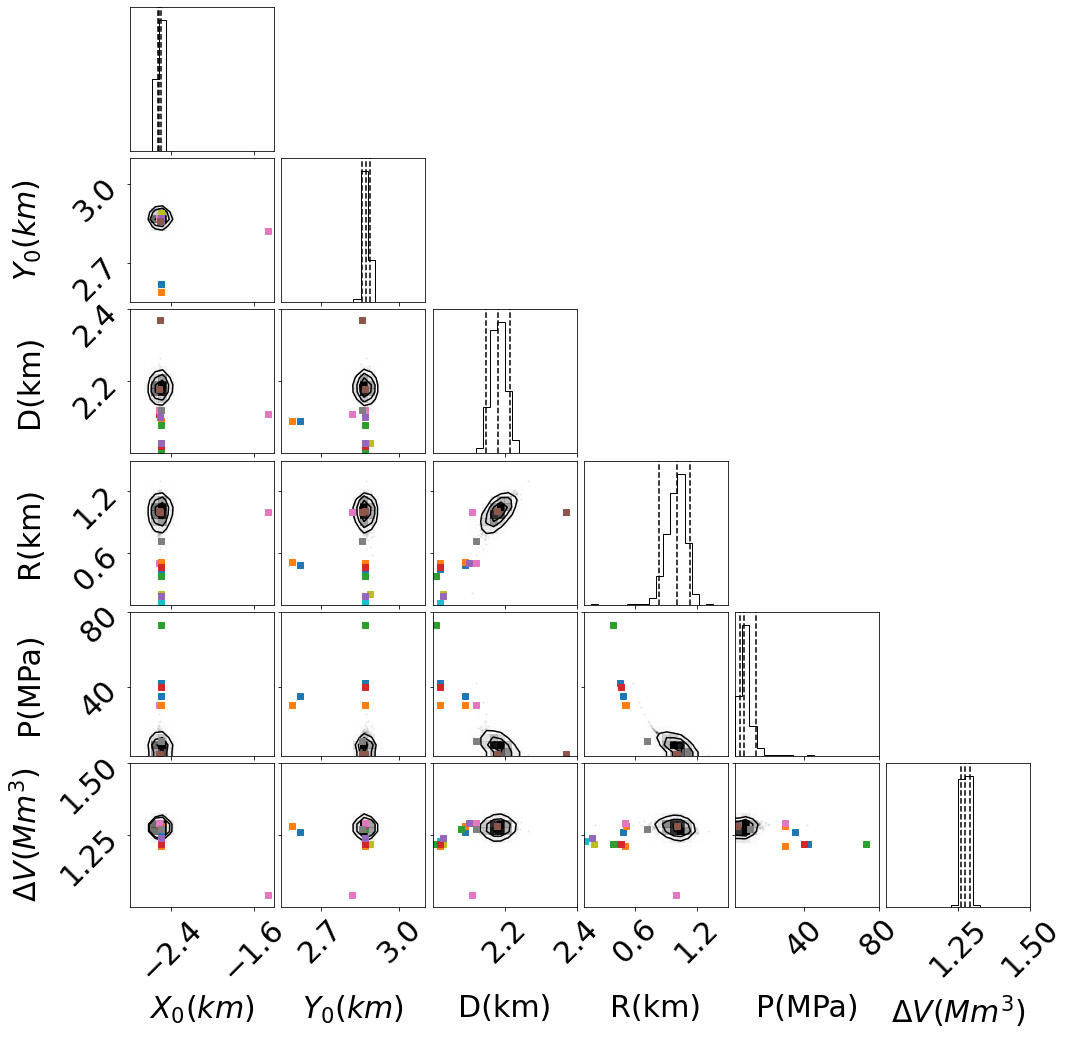

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
data=[]
labels=[]
parnames,orders=inv.get_parnames_orders()
for i,tr in enumerate(trace):
    data.append(tr[:])
    labels.append(parnames[i])
data=np.vstack(data)
newdata=np.zeros((data.shape[0]+1,data.shape[1]))
newdata[:,:]=np.nan
newdata[0:4,:]=np.copy(data[0:4,:])
newdata[4,:]=np.copy(data[4,:]*2e10/(np.pi*data[3,:]**3))
newdata[5,:]=np.copy(data[4,:])

data=np.copy(newdata)
data[0,:]=data[0,:]/1e3
data[1,:]=data[1,:]/1e3
data[2,:]=data[2,:]/1e3
data[3,:]=data[3,:]/1e3
data[4,:]=data[4,:]/1e6
data[5,:]=data[5,:]/1e6
labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$','D(km)','R(km)','P(MPa)','$\Delta{V} (Mm^{3})$']

trus1=[-2.50,2.62,2.09,0.48,35,1.26]
trus2=[-2.50,2.59,2.09,0.51,30,1.28]
trus3=[-2.50,2.87,2.08,0,0,1.27]
trus4=[-2.52,2.87,2.11,0,0,1.29]
trus5=[-2.51,2.87,2.10,0.5,0,1.29]
trus6=[-2.52,2.87,2.18,1.01,4,1.28]
trus7=[-2.52,2.87,2.12,0.50,30,1.29]
trus8=[-2.50,2.86,2.12,0.72,11,1.27]
trus9=[-2.50,2.89,2.03,0.20,484,1.22]
trus10=[-2.50,2.87,2.02,0.11,3340,1.23]
trus11=[-2.50,2.87,2.02,0.45,42,1.22]
trus12=[-2.50,2.87,2.02,0.50,30,1.21]
trus13=[-2.50,2.87,2.01,0.38,73,1.22]
trus14=[-2.50,2.87,2.02,0.46,40,1.22]
trus15=[-2.50,2.87,2.03,0.18,710,1.24]
trus16=[-2.51,2.86,2.37,1.00,4,0]
trus17=[-1.46,2.82,2.11,1.00,0,1.04]

trus=[trus1,trus2,trus3,trus4,trus5,trus6,trus7,trus8,trus9,trus10,trus11,trus12,trus13,trus14,trus15,trus16,trus17]

ranges=[(-2.8,-1.40),(2.55,3.1),(2.0,2.4),(0.1,1.5),(3,80),(1.0,1.5)]
plt.rcParams.update({'font.size': 30})
figure = corner.corner(data.T, labels=labels,
                       quantiles=[0.05, 0.5, 0.95],smooth=0.7,range=ranges,max_n_ticks=2,labelpad=0.3,
                       show_titles=False, label_kwargs={"fontsize": 30}, title_kwargs={"fontsize": 30})

for i,tru in enumerate(trus):
    #corner.overplot_lines(figure, np.array(tru), color="C"+str(i),linewidth=1)
    corner.overplot_points(figure, np.array(tru)[None], color="C"+str(i),marker='s')

plt.savefig('histograms')

## Forward model for the median solution

[-2.51708347e+03  2.87271304e+03  2.18211177e+03  1.00563693e+03
  1.27511496e+06]


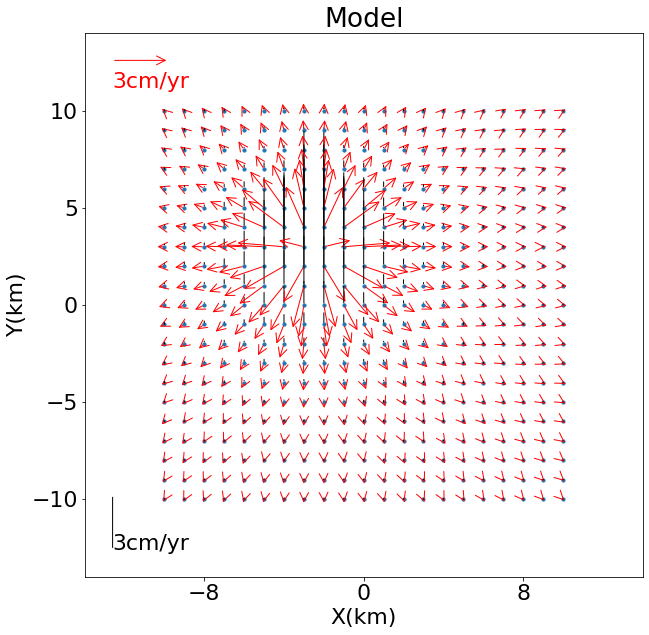

In [13]:
xbest=np.array([np.median(data[0,:])*1e3,np.median(data[1,:])*1e3,np.median(data[2,:])*1e3,np.median(data[3,:])*1e3,np.median(data[5,:])*1e6])
print(xbest)
uxsm,uysm,uzsm=mct.forward(xbest,unravel=False)
plt.rcParams.update({'font.size': 22})
util.plot_gnss(xs,ys,uxsm,uysm,uzsm,title='Model',scl=3,figsize=(10,10))

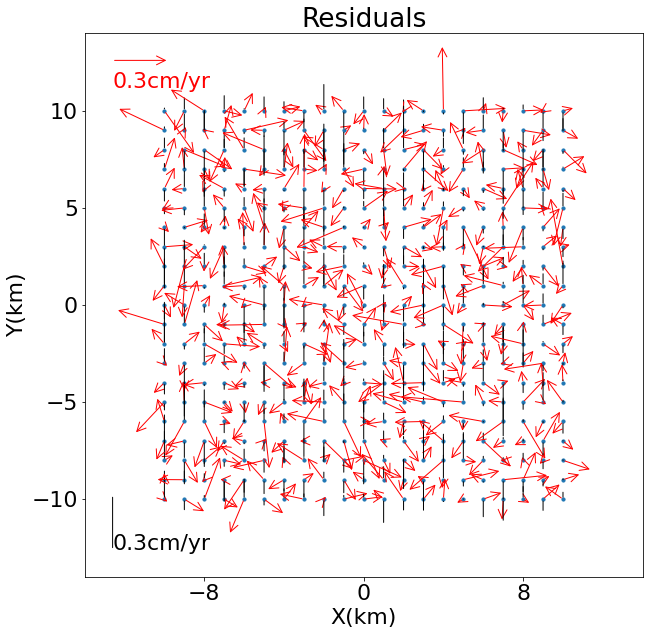

In [17]:
util.plot_gnss(xs,ys,uxs-uxsm,uys-uysm,uzs-uzsm,title='Residuals',scl=0.3,figsize=(10,10))

In [17]:
means=[np.percentile(data[i,:],50) for i in range(data.shape[0])]
lower95=[np.percentile(data[i,:],5) for i in range(data.shape[0])]
upper95=[np.percentile(data[i,:],95) for i in range(data.shape[0])]
lower32=[np.percentile(data[i,:],32) for i in range(data.shape[0])]
upper68=[np.percentile(data[i,:],68) for i in range(data.shape[0])]

results=[means,lower95,upper95,lower32,upper68]

for res in results:
    for i in range(len(res)):
        if i in [0,1,2,3]:
            res[i]=res[i]*1e3
        elif i in [4,5]:
            res[i]=res[i]*1e6
        elif i in [6,7]:
            res[i]=res[i]/1e2
    print("%4.0f,%4.0f,%4.0f,%3.0f,%2.0f,%2.0f"%(tuple(res)))


-2517,2873,2182,1006,7990439,1275115
-2533,2858,2149,831,5581917,1258664
-2501,2889,2216,1132,14304262,1292169
-2521,2869,2173,961,7132722,1270282
-2513,2878,2192,1044,9146289,1279423
